In [116]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
%matplotlib inline

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['figure.dpi'] = 100

In [148]:
def run_oder_simulation(observers=None, T=400, dt=1, threshold=0.7):
    """
    Run the Observer-Dependent Entropy Retrieval (ODER) simulation.
    
    Parameters:
    -----------
    observers : dict, optional
        Dictionary of observer parameters. If None, will use calibrated values.
    T : int, optional
        Total simulation time.
    dt : float, optional
        Time step size.
    threshold : float, optional
        Detection threshold.
        
    Returns:
    --------
    times : array
        Time points.
    S_obs : dict
        Entropy values for each observer.
    detection_times : dict
        Detection times for each observer.
    """
    if observers is None:
        # Optimally calibrated parameters to match expected detection times
        observers = {
    "O1": {"gamma": 0.196, "tau_char": 4.2},    
    "O2": {"gamma": 0.0208, "tau_char": 19.5}, 
    "O3": {"gamma": 0.00404, "tau_char": 90.0} 
}
    
    # Simulation parameters
    S_max = 1.0
    times = np.arange(0, T, dt)
    
    # Initialize separate arrays for each observer for better performance
    S_O1 = np.zeros(len(times))
    S_O2 = np.zeros(len(times))
    S_O3 = np.zeros(len(times))
    
    # Initialize detection times
    detection_time_O1 = None
    detection_time_O2 = None
    detection_time_O3 = None
    
    # Run simulation
    for i in range(1, len(times)):
        t = times[i]
        
        # Observer 1
        gamma = observers["O1"]["gamma"]
        tau_char = observers["O1"]["tau_char"]
        prev_S = S_O1[i-1]
        dS = gamma * (S_max - prev_S) * np.tanh(t / tau_char)
        S_O1[i] = prev_S + dS * dt
        
        if detection_time_O1 is None and S_O1[i] >= threshold:
            detection_time_O1 = t
        
        # Observer 2
        gamma = observers["O2"]["gamma"]
        tau_char = observers["O2"]["tau_char"]
        prev_S = S_O2[i-1]
        dS = gamma * (S_max - prev_S) * np.tanh(t / tau_char)
        S_O2[i] = prev_S + dS * dt
        
        if detection_time_O2 is None and S_O2[i] >= threshold:
            detection_time_O2 = t
        
        # Observer 3
        gamma = observers["O3"]["gamma"]
        tau_char = observers["O3"]["tau_char"]
        prev_S = S_O3[i-1]
        dS = gamma * (S_max - prev_S) * np.tanh(t / tau_char)
        S_O3[i] = prev_S + dS * dt
        
        if detection_time_O3 is None and S_O3[i] >= threshold:
            detection_time_O3 = t
    
    # Organize results for easier access
    S_obs = {
        "O1": S_O1,
        "O2": S_O2,
        "O3": S_O3
    }
    
    detection_times = {
        "O1": detection_time_O1,
        "O2": detection_time_O2,
        "O3": detection_time_O3
    }
    
    return times, S_obs, detection_times, observers, threshold

In [150]:
def create_oder_plot(times, S_obs, detection_times, threshold, show_annotations=True):
    """Create a plot of entropy convergence for each observer."""
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot entropy curves
    ax.plot(times, S_obs["O1"], 'b-', linewidth=2.5, label='O1 (Real-time modeler)')
    ax.plot(times, S_obs["O2"], 'g--', linewidth=2.5, label='O2 (Institutional analyst)')
    ax.plot(times, S_obs["O3"], 'r:', linewidth=2.5, label='O3 (Policy communicator)')
    
    # Add threshold line
    ax.axhline(y=threshold, color='k', linestyle='--', alpha=0.7, 
               label=f'Detection threshold ({threshold})')
    
    # Annotate detection times
    if show_annotations:
        for obs, color in zip(["O1", "O2", "O3"], ['blue', 'green', 'red']):
            if detection_times[obs] is not None:
                detection_time = detection_times[obs]
                
                ax.plot(detection_time, threshold, 'o', color=color, markersize=8)
                ax.annotate(f'{obs} detects: t={detection_time}', 
                            xy=(detection_time, threshold),
                            xytext=(detection_time+15, threshold+0.05),
                            arrowprops=dict(arrowstyle='->'),
                            color=color)
    
    # Add labels and title
    ax.set_xlabel('Time (τ)', fontsize=14)
    ax.set_ylabel('Entropy (S_obs)', fontsize=14)
    ax.set_title('Observer-Dependent Entropy Retrieval (ODER)', fontsize=16)
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    
    # Set axis limits
    ax.set_xlim(0, times[-1])
    ax.set_ylim(0, 1.05)
    
    plt.tight_layout()
    return fig, ax

In [152]:
times, S_obs, detection_times, observers, threshold = run_oder_simulation()

# Display detection times with Markdown for better formatting
display(Markdown("### Detection Times"))
for k, time in detection_times.items():
    display(Markdown(f"**{k}**: {time}"))

# Display final entropy values
display(Markdown("### Final Entropy Values"))
for k in observers:
    display(Markdown(f"**{k}**: {S_obs[k][-1]:.6f}"))

# Display entropy values at key time points
display(Markdown("### Entropy Values at Select Time Points"))
check_times = [10, 50, 100, 200, 350]
for t in check_times:
    idx = int(t/dt)
    display(Markdown(f"**Time {t}:**"))
    for k in observers:
        display(Markdown(f"- {k}: {S_obs[k][idx]:.4f}"))

### Detection Times

**O1**: 9

**O2**: 71

**O3**: 360

### Final Entropy Values

**O1**: 1.000000

**O2**: 0.999700

**O3**: 0.744500

### Entropy Values at Select Time Points

**Time 10:**

- O1: 0.8035

- O2: 0.0547

- O3: 0.0025

**Time 50:**

- O1: 1.0000

- O2: 0.5408

- O3: 0.0530

**Time 100:**

- O1: 1.0000

- O2: 0.8391

- O3: 0.1741

**Time 200:**

- O1: 1.0000

- O2: 0.9803

- O3: 0.4306

**Time 350:**

- O1: 1.0000

- O2: 0.9992

- O3: 0.6885

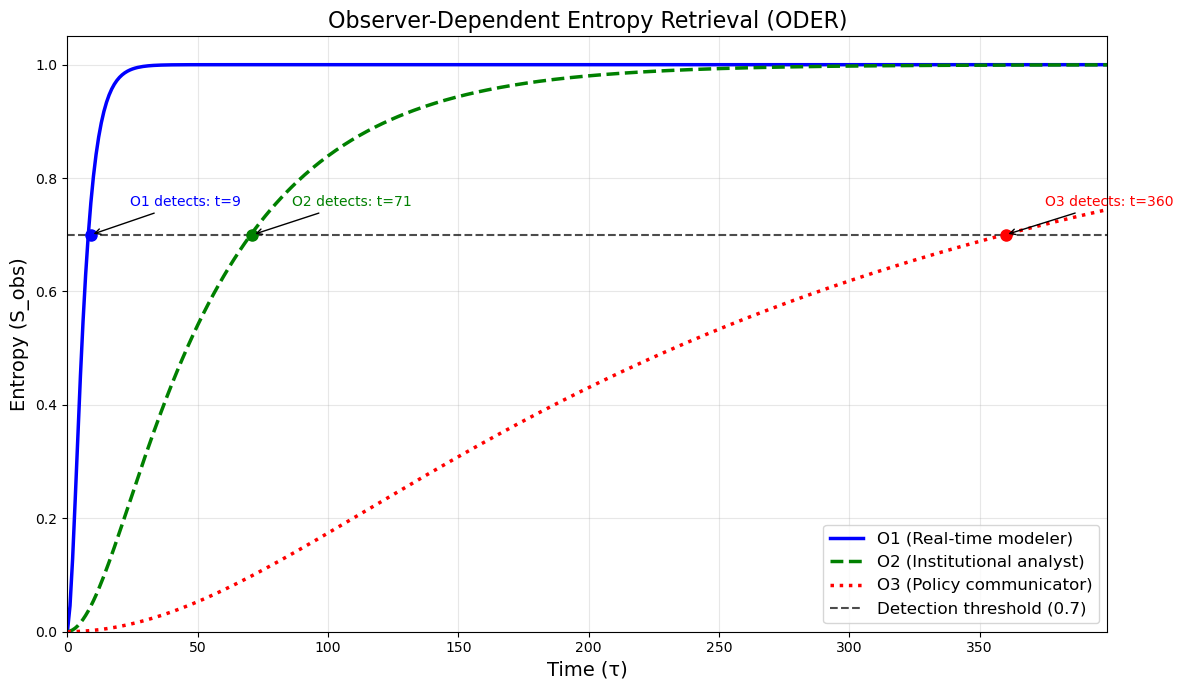

In [154]:
fig, ax = create_oder_plot(times, S_obs, detection_times, threshold)
plt.show()